# Search GEDI L2B and plot canopy heights

In this tutorial we will use the integrated Earthdata serch function in MAAP ADE (https://ade.ops.maap-project.org/) to search for some GEDI L2B data for an area of interest. We will then download some of this data and read its attributes in preparation for some analysis. We will perform a spatial subset on the data to reduce data volumes and we will finally make some basic plots of our data. We will start by importing some of the modules we will need.

In [ ]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.ops.maap-project.org')
import geopandas as gpd
import folium
import h5py
import pandas
import matplotlib
import matplotlib.pyplot as plt

We will search and download GEDI L2B data using the bounding box of a vector AOI. Firstly, an AOI over the Shenandoah National Park will be created and then we will plot its location on a map.

In [ ]:
# Using bounding coordinates to create a polygon around Shenadoah National Park
lon_coords = [-78.32129105072025, -78.04618813890727, -78.72985973163064, -79.0158578082679, -78.32129105072025]
lat_coords = [38.88703610703791, 38.74909216350823, 37.88789051477522, 38.03177640342157, 38.88703610703791]

polygon_geom = Polygon(zip(lon_coords, lat_coords))
crs = 'epsg:4326'
AOI = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])

We can get the bounding box of the AOI so we can use it as a spatial limit on our data search. GeoPandas has a function for returning the spatial coordinates of a bounding box:

In [ ]:
# Get the bounding box of the shp
bbox = AOI.bounds
# print the bounding box coords
print('minx = ', bbox['minx'][0])
print('miny = ', bbox['miny'][0])
print('maxx = ', bbox['maxx'][0])
print('maxy = ', bbox['maxy'][0])

Lets look at our AOI on an interactive map using folium.

In [ ]:
m = folium.Map(location=[38.5, -78], zoom_start=9, tiles='CartoDB positron')
geo_j = folium.GeoJson(data=AOI, style_function=lambda x: {'fillColor': 'orange'})
geo_j.add_to(m)
m

Search Data: To search GEDI data we can use the EarthData search integration in the MAAP ADE. Open the Earthdata search toolbar by clicking on the following:

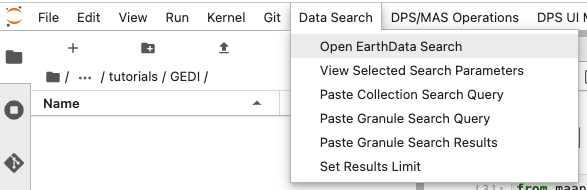/EarthdataSearch.png)

This will open up the EarthData search interface in a new tab. We can use the search bar to search GEDI L2B data. By entering "L2B" in the search bar, we can see the relevant GEDI data is filtered. Click on the dataset to get more details.

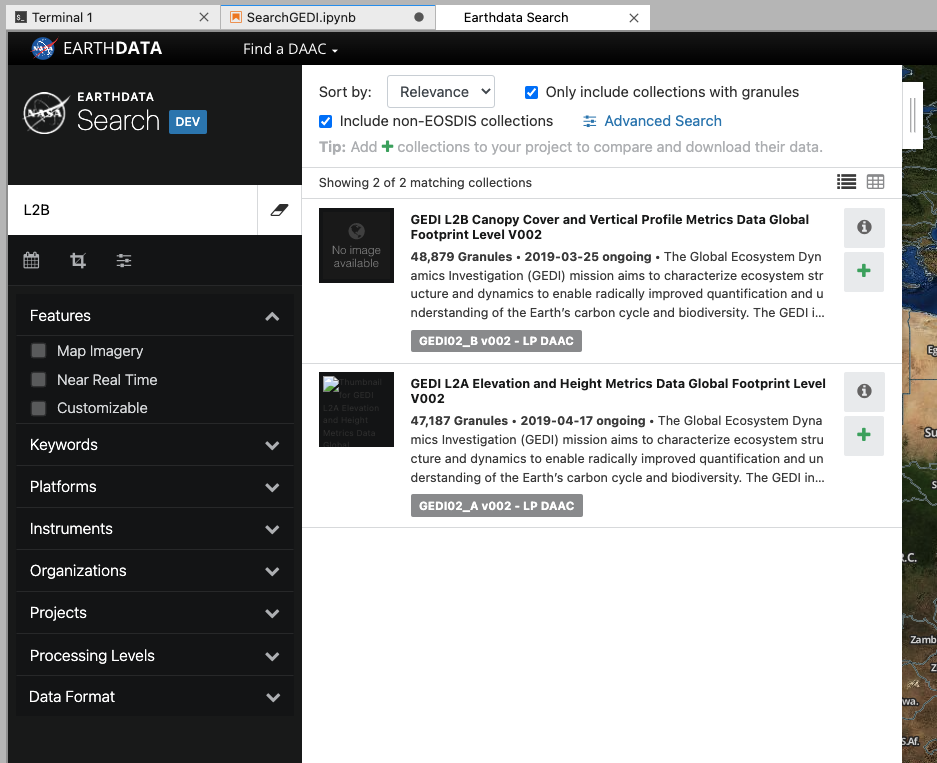

While we have been searching for data, the MAAP ADE has been keeping a track of our search parameters. This means that we can easily insert our search for GEDI data straight into our notebook.

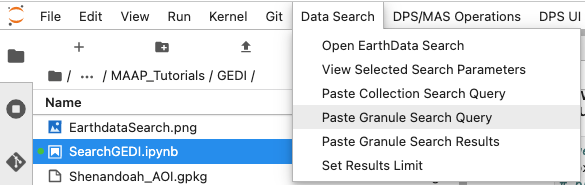

This gives us our search parameters in our notebook using the GEDI dataset id. The default limit for the number of returned results in 1000. Running this will produce 1000 results, but we can look at the first one by indexing the list of returned results. This is what the data entry looks like. You can see a large amount of metadata for the file along with the URL for where this specific file is stored.

In [ ]:
# generated from this EDSC search: https://ade.ops.maap-project.org:30052/search/granules?p=C1201460047-NASA_MAAP&q=L2B&tl=1647961605!4!!
data = maap.searchGranule(concept_id="C1201460047-NASA_MAAP", limit=1000)[0]
data

So far, this search function requests all of the GEDI data but we can add a spatial subset filter using our AOI from above to limit the results. Adding spatial filter returns 176 GEDI L2B files that intersect with our AOI.

In [ ]:
data_aoi = maap.searchGranule(concept_id="C1201460047-NASA_MAAP", bounding_box="-79.0158578082679,37.88789051477522,-78.04618813890727,38.887036107037915", limit=1000)
print(len(data_aoi))

This is more data than we need, so lets look at the contents of a single GEDI file. Firstly we need to bring it from the server side (S3) to our local side. This can be done using the MAAP function getData. Here we will pull the 7th file in our search results.

In [ ]:
gedi_data = data_aoi[6].getData('./')
print(gedi_data)

GEDI data has 8 beams. So, we will check that all beams are in our file and print a list of the available beams.

In [ ]:
gedi_h5_file = h5py.File(gedi_data, 'r')
gedi_keys = list(gedi_h5_file.keys())
gedi_beams = ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
gedi_beams_lst = []
for gedi_beam_name in gedi_keys:
    if gedi_beam_name in gedi_beams:
        gedi_beams_lst.append(gedi_beam_name)
print(gedi_beams_lst)

For each beam we need to get all of the data and metrics associated with it. For this, we have a function that will gather all of the metrics we want and put them into a geopandas dataframe:

In [ ]:
def get_gedi_df(gedi_h5_file, gedi_beam_name):
    gedi_beam = gedi_h5_file[gedi_beam_name]
    
    # Get location info.
    gedi_beam_geoloc = gedi_beam['geolocation']
    # Get land cover data.
    gedi_beam_landcover = gedi_beam['land_cover_data']

    gedi_beam_df = pandas.DataFrame(
            {'elevation_bin0'         : gedi_beam_geoloc['elevation_bin0'],
             'elevation_lastbin'      : gedi_beam_geoloc['elevation_lastbin'],
             'height_bin0'            : gedi_beam_geoloc['height_bin0'],
             'height_lastbin'         : gedi_beam_geoloc['height_lastbin'],
             'shot_number'            : gedi_beam_geoloc['shot_number'],
             'solar_azimuth'          : gedi_beam_geoloc['solar_azimuth'],
             'solar_elevation'        : gedi_beam_geoloc['solar_elevation'],
             'latitude_bin0'          : gedi_beam_geoloc['latitude_bin0'],
             'latitude_lastbin'       : gedi_beam_geoloc['latitude_lastbin'],
             'longitude_bin0'         : gedi_beam_geoloc['longitude_bin0'],
             'longitude_lastbin'      : gedi_beam_geoloc['longitude_lastbin'],
             'degrade_flag'           : gedi_beam_geoloc['degrade_flag'],
             'digital_elevation_model': gedi_beam_geoloc['digital_elevation_model'],
             'landsat_treecover'      : gedi_beam_landcover['landsat_treecover'],
             'modis_nonvegetated'     : gedi_beam_landcover['modis_nonvegetated'],
             'modis_nonvegetated_sd'  : gedi_beam_landcover['modis_nonvegetated_sd'],
             'modis_treecover'        : gedi_beam_landcover['modis_treecover'],
             'modis_treecover_sd'     : gedi_beam_landcover['modis_treecover_sd'],
             'beam'                   : gedi_beam['beam'],
             'cover'                  : gedi_beam['cover'],
             'master_frac'            : gedi_beam['master_frac'],
             'master_int'             : gedi_beam['master_int'],
             'num_detectedmodes'      : gedi_beam['num_detectedmodes'],
             'omega'                  : gedi_beam['omega'],
             'pai'                    : gedi_beam['pai'],
             'pgap_theta'             : gedi_beam['pgap_theta'],
             'pgap_theta_error'       : gedi_beam['pgap_theta_error'],
             'rg'                     : gedi_beam['rg'],
             'rh100'                  : gedi_beam['rh100'],
             'rhog'                   : gedi_beam['rhog'],
             'rhog_error'             : gedi_beam['rhog_error'],
             'rhov'                   : gedi_beam['rhov'],
             'rhov_error'             : gedi_beam['rhov_error'],
             'rossg'                  : gedi_beam['rossg'],
             'rv'                     : gedi_beam['rv'],
             'sensitivity'            : gedi_beam['sensitivity'],
             'stale_return_flag'      : gedi_beam['stale_return_flag'],
             'surface_flag'           : gedi_beam['surface_flag'],
             'l2a_quality_flag'       : gedi_beam['l2a_quality_flag'],
             'l2b_quality_flag'       : gedi_beam['l2b_quality_flag']})

    gedi_beam_gdf = gpd.GeoDataFrame(gedi_beam_df, crs='EPSG:4326',
                                           geometry=gpd.points_from_xy(gedi_beam_df.longitude_lastbin,
                                                                             gedi_beam_df.latitude_lastbin))
    return gedi_beam_gdf

To access the data with this function, we can call the function for each beam id that we have:


In [ ]:
BEAM0000 = get_gedi_df(gedi_h5_file, 'BEAM0000')
BEAM0001 = get_gedi_df(gedi_h5_file, 'BEAM0001')
BEAM0010 = get_gedi_df(gedi_h5_file, 'BEAM0010')
BEAM0011 = get_gedi_df(gedi_h5_file, 'BEAM0011')
BEAM0101 = get_gedi_df(gedi_h5_file, 'BEAM0101')
BEAM0110 = get_gedi_df(gedi_h5_file, 'BEAM0110')
BEAM1000 = get_gedi_df(gedi_h5_file, 'BEAM1000')
BEAM1011 = get_gedi_df(gedi_h5_file, 'BEAM1011')

Now we can look at the data in one of the dataframes (beams). We can see that there are 108583 GEDI shots (108583 entries in each column).

In [ ]:
print(BEAM0000.head())
print('number of rows = ', len(BEAM0000))

Before  displaying this data we can do a spatial subset to remove the data outside of our AOI by doing a spatial subset. We use the Geopandas clip function to clip out the GEDI data based on the extent of our AOI. This reduces the size of the dataframe from 108583 rows to 508.

In [ ]:
BEAM0000_sub = gpd.clip(BEAM0000, AOI)
len(BEAM0000_sub)


We can display this subset of data over our AOI extent.

In [ ]:
m = folium.Map(location=[38.5, -78], zoom_start=9, tiles='CartoDB positron')

geo_j = folium.GeoJson(data=AOI, style_function=lambda x: {'fillColor': 'orange'})
geo_j.add_to(m)

geo_g = folium.GeoJson(data=BEAM0000_sub,marker = folium.CircleMarker(radius = 1, # Radius in metres
                                           weight = 0, #outline weight
                                           fill_color = '#FF0000', 
                                           fill_opacity = 1))
geo_g.add_to(m)
m

Now we have this subset of data, we can look at some of the GEDI metrics over our area of interest. The 'rh100' metric should give us the top of the canopy heights. What does this look like over Shenandoah National Park? We will look at the ground height and the 'rh100' above ground. The DEM metric is in meters (m) and the 'rh100' metric is in centimeters (cm) above the ground height. Therefore we must add the 'rh100' value to the ground height to get the total height of the tree for display purposes. The 'rh100' metric is also converted to meters (m) to normalize the units

In [ ]:
latitude = BEAM0000_sub['latitude_lastbin']
rh100 = BEAM0000_sub['rh100']
ground = BEAM0000_sub['digital_elevation_model']

TreeHeight = ground + rh100/100

Finally we can make a plot of the ground surface and the canopy heights above the ground surface. We can see the forest canopies in green above the topographically complex ground in brown.

In [ ]:
plt.figure(figsize=(20, 5))
plt.scatter(latitude, TreeHeight, c='green')
plt.plot(latitude, ground, c='brown')

Now you have this basic structure you can investigate some of the other metrics and GEDI beams to understand more about the data.